In [1]:
import wave
from scipy.signal import spectrogram
import soundfile as sf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy

In [2]:
data, samplerate = sf.read(
    '/Users/GodSpeed/Documents/Courses/Machine Learning/Project/LibriSpeech/dev-clean/84/121123/84-121123-0004.flac')

In [8]:
print len(data)
print samplerate
#taking 20ms samples
fft_length = 0.001 * 20 * samplerate
overlap_length = 0.001 * 10 * samplerate
#print window_size
f, t, Sxx = spectrogram(data, fs = samplerate, nperseg = fft_length, 
                        noverlap = overlap_length)
print "No. of sample frequencies: ", len(f) #len(signal.spectrogram(data)[0])
print "No. of time segmnets:", len(t)
print "Spectrogram length: ", len(Sxx)
print Sxx.shape
#data is in the form [frequencies[time]]
#print type(Sxx)
#for i in range(len(t) -  1):
#    print t[i+1] - t[i]

70400
16000
No. of sample frequencies:  161
No. of time segmnets: 439
Spectrogram length:  161
(161, 439)


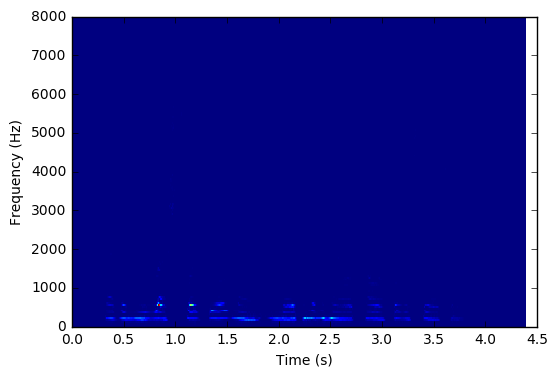

In [9]:
plt.pcolormesh(t,f,Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()
#print Sxx[:,313]

## Output labels

In [10]:
output_labels = {}
for i in range(26):
    output_labels[i] = chr(i+97)
output_labels[i+1] = ' '
output_labels

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: ' '}

### Initialize weights
Following conventions in SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS

In [31]:
#set layer sizes
layers_sizes = [len(Sxx), 200, len(output_labels)]
input_size = len(Sxx)

"""this function is to initialize wi, 
weights from input layer to first hidden layer,
in the form [input layer[hidden layer]]"""
def initialize_wx(layers_sizes):
    input_size = layers_sizes[0]
    first_hidden_layer_size = layers_sizes[1]
    e = np.sqrt(6)/np.sqrt(input_size + first_hidden_layer_size)
    wx = np.dot(np.random.rand(input_size, 
                               first_hidden_layer_size), 2*e) - e
    return wx

"""this function is to initialize wh,
weights from each hidden layer to next hidden layer
creating wh array as [layer number[input layer[output layer]]]"""
def initialize_W_hh_next(layers_sizes):
    hidden_layers_sizes = layers_sizes[1:-1]
    num_layers = len(hidden_layers_sizes)
    #return empty if only one hidden layer
    if num_layers == 1:
        return
    wh = np.zeros((num_layers - 1, max(hidden_layers_sizes),
                   max(hidden_layers_sizes[1:len(hidden_layers_sizes)])))
    for i in range(num_layers - 1):
        e = np.sqrt(6)/np.sqrt(hidden_layers_sizes[i]+hidden_layers_sizes[i+1])
        wh[i, 0:hidden_layers_sizes[i], 0:hidden_layers_sizes[i+1]] = np.dot(
            np.random.rand((hidden_layers_sizes[i]), hidden_layers_sizes[i+1]),
            2*e)-e
    return wh

"""this function is to initialize wi, 
weights from last hidden layer to output layer,
in the form [hidden layer[output layer]]"""
def initialize_wo(layers_sizes):
    last_hidden_layer_size = layers_sizes[-2]
    output_size = layers_sizes[-1]
    wo = initialize_wx([layers_sizes[-2],layers_sizes[-1]])
    return wo

"""initialize recurrent weights for hidden layer on itself"""
def initialize_wh(layers_sizes):
    hidden_layers_sizes = layers_sizes[1:-1]
    num_hidden_layers = len(hidden_layers_sizes)
    wh = np.zeros((max(hidden_layers_sizes), num_hidden_layers))
    #print w_hh_curr.shape
    #return
    for i in range(num_hidden_layers):
        e = np.sqrt(6)/np.sqrt(2*hidden_layers_sizes[0])
        wh[0:hidden_layers_sizes[i], i] = np.dot(
            np.random.rand(hidden_layers_sizes[i]), 2*e) - e
    return wh

def initialize_wc(layers_sizes):
    wc = initialize_wh(layers_sizes)
    return wc


#initialize weights from input to 1st hidden layer
w_xi = initialize_wx(layers_sizes)

#initialize w_hi
w_hi = initialize_wh(layers_sizes)

#initialize w_ci
w_ci = initialize_wc(layers_sizes)

#initialize w_xf
w_xf = initialize_wx(layers_sizes)

#initialize w_hf
w_hf = initialize_wh(layers_sizes)

#initialize w_cf
w_cf = initialize_wc(layers_sizes)

#initialize w_xc
w_xc = initialize_wx(layers_sizes)

#initialize w_hc
w_hc = initialize_wh(layers_sizes)

#initialize w_xo
w_xo = initialize_wx(layers_sizes)

#initialize w_ho
w_ho = initialize_wh(layers_sizes)

#initialize w_co
w_co = initialize_wc(layers_sizes)


#initialize weights from each hidden layer to next hidden layer
wh_next = initialize_W_hh_next(layers_sizes)

#initialize weights from last hidden layer to output layer
w_hy = initialize_wo(layers_sizes)

#initialize recurrent weights to 0
#w_hh_curr = initialize_w_hh_curr(layers_sizes)

#print w_hi.shape
#print w_xi.shape
#print wh_next.shape
#print w_hy.shape
#print w_hh_curr.shape

Initialize h(t-1) and c(t-1) to 0

In [33]:
def initialize_empty_state(layers_sizes):
    hidden_layers_sizes = layers_sizes[1:-1]
    num_hidden_layers = len(hidden_layers_sizes)
    empty_state = np.zeros((max(hidden_layers_sizes), num_hidden_layers))
    return empty_state

hidden_state_prev = initialize_empty_state(layers_sizes)
cell_state_prev = initialize_empty_state(layers_sizes)
print hidden_state_prev.shape
print cell_state_prev.shape

(200, 1)
(200, 1)


In [34]:
print Sxx.shape
print len(t)
print len(f)

(161, 439)
439
161


## RNN architecture

In [38]:
def sigmoid(z):
    a = 1.0/(1.0+np.exp((-z)))
    return a

sample_size = len(t)
frequencies = f
input = Sxx
for i in range(sample_size):
    #print w_xi.shape
    #print Sxx[:,i].shape
    #input_gate = sigmoid(w_xi*Sxx[:,i] + w_hi*hidden_state_prev + w_ci * cell_state_prev + 1)

NameError: name 'reshape' is not defined

In [ ]:
def sigmoid(z):

    # Local Variables: a, z
    # Function calls: exp, sigmoid
    a = 1.0/(1.0+np.exp((-z)))
    return a

def SGD_training(training_data, training_labels, validation_data, 
                 validation_labels, testing_data, testing_labels, LS, input_theta, delta_weight_prev, epochs):
    
    for i in range(training.size[1]):
        input_gate = sigmoid(input_that.transpose)

    # Local Variables: validation_error, samples_num, epochs, patience, validation_labels, error_min_index, RP, training_labels, all_layers_out, epoch, LS, theta, testing_images, accuracy, D, error_min_patience, learning_rate, error, batch_size, delta_weight_prev, Y, NL, a, validation_images, training_images, sample_set, i, break_point, num_of_labels, l, theta_best, testing_labels, training_error
    # Function calls: gca, rand, set, legend, num2str, figure, fwd_propagation, predict, title, sum, bwd_propagation, plot, ceil, forward_prop, ylabel, zeros, SGD_training, xlabel, Inf, validate, size
    #this function trains the neural network
    samples_num = training_data.size()
    NL = matcompat.size(LS, 2.)
    #%num of layers including input and output
    learning_rate = 0.1
    RP = 0.8
    #%regularization parameter
    #%Y = zeros(samples_num, LS(NL));
    patience = 150.
    #%number of epochs to skip for early stopping
    error_min_patience = Inf
    #%window_error = 0;   %error in the window to check improvement in validation
    num_of_labels = 10.
    D = np.zeros(num_of_labels, samples_num)
    #%D has desired response such that for any label, the bit for its index is 1
    #%in 10 digit binary vector D(sample_number,:) for that sample
    for l in np.arange(1., (num_of_labels-1.)+1):
        D[int(l)-1,:] = training_labels == l
        
    D[9,:] = training_labels == 0.
    #%epochs = 150;
    #%e = zeros(epochs,1);
    batch_size = 100.
    sample_set = np.zeros(batch_size, 1.)
    training_error = np.zeros(epochs, 1.)
    #%mean_training_error = zeros(epochs, 1);
    validation_error = np.zeros(epochs, 1.)
    #%mean_validation_error = zeros(epochs, 1);
    accuracy = np.zeros(epochs, 1.)
    for epoch in np.arange(1., (epochs)+1):
        for i in np.arange(1., (batch_size)+1):
            sample_set[int(i)-1,0] = np.ceil(np.dot(np.random.rand(1.), matcompat.size(training_images, 1.)))
            a = fwd_propagation(training_images[int(sample_set[int(i)-1])-1,:], theta, NL, LS).T
            #%changed a to form (units_in_layer by layer_number)
            [theta, delta_weight_prev] = bwd_propagation(a, theta, delta_weight_prev, D[:,int(sample_set[int(i)-1])-1], learning_rate, RP, NL, LS)
            
        #%error = 0;
        all_layers_out = forward_prop(training_images[int(sample_set)-1,:], theta, NL, LS)
        Y = all_layers_out[0:LS[int(NL)-1],:,int(NL)-1]
        error = (Y-D[:,int(sample_set)-1])**2.
        training_error[int(epoch)-1,0] = matdiv(np.sum(np.sum(error, 1.)), batch_size)
        validation_error[int(epoch)-1,0] = validate(theta, validation_images, validation_labels, NL, LS)
        accuracy[int(epoch)-1,0] = predict(theta, testing_images, testing_labels, NL, LS)
        if epoch >= patience:
            if validation_error[int(epoch)-1,0]<=error_min_patience:
                error_min_patience = validation_error[int(epoch)-1,0]
                error_min_index = epoch
                theta_best = theta
            
            
            if epoch > error_min_index+20.:
                #%taking window of 10 epochs
            break_point = epoch
            break
            #%window_error = sum(validation_error(error_min_index:epoch));
            #%else
            #%   window_mean = 
            
        
        
        break_point = epochs
        
    training_error = training_error[0:break_point]
    validation_error = validation_error[0:break_point]
    accuracy = accuracy[0:break_point]
    plt.figure()
    plt.plot(np.arange(1., (break_point)+1), validation_error, 'LineWidth', 1.5)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Square Error')
    plt.legend('Training Error', 'Validation Error')
    plt.title(np.array(np.hstack(('Performance for a batch size of ', num2str(batch_size)))))
    set(plt.gca, 'fontsize', 23.)
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.title(np.array(np.hstack(('Accuracy percentage curve for batch size of ', num2str(batch_size)))))
    set(plt.gca, 'fontsize', 23.)
    return [training_error, validation_error, accuracy, theta_best, break_point]